In [11]:
# ================================================
# SEGMENTACIÓN DE CLIENTES CON K-MEANS (TIPVOS)
# Proyecto II Bimestre – Data Scientist
# ================================================

# 1. Conexión a Supabase y carga de datos
import pandas as pd
from sqlalchemy import create_engine
import os
import joblib
from datetime import datetime

# --- Configuración de Conexión a la Base de Datos PostgreSQL Local ---
db_user = 'postgres'
db_password = 'postgres'
db_host = 'localhost'
db_port = '5433'
db_name = 'Tipvos' # Nombre de la base de datos

# Construir la cadena de conexión para PostgreSQL local
engine_string = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(engine_string)
# Consulta: unir fact_ventas con dim_cliente
consulta = """
SELECT 
    f.invoice,
    f.fecha,
    f.customer_id,
    f.stockcode,
    f.cantidad,
    f.precio_unitario,
    d.pais
FROM fact_ventas f
JOIN dim_cliente d ON f.customer_id = d.customer_id
"""

df = pd.read_sql(consulta, engine)
df.head()

# 2. Procesamiento y limpieza
df.dropna(subset=["invoice", "fecha", "customer_id", "stockcode", "cantidad", "precio_unitario"], inplace=True)
df = df[(df["cantidad"] > 0) & (df["precio_unitario"] > 0)]

# Crear columna 'total'
df["total"] = df["cantidad"] * df["precio_unitario"]
df.info()

# 3. Cálculo de métricas RFM
from datetime import datetime, timedelta

fecha_ref = df["fecha"].max() + pd.Timedelta(days=1)

rfm = df.groupby("customer_id").agg({
    "fecha": lambda x: (fecha_ref - x.max()).days,   # Recencia
    "invoice": "nunique",                            # Frecuencia
    "total": "sum"                                   # Monto
}).reset_index()

rfm.columns = ["customer_id", "recencia", "frecuencia", "monto"]
rfm.describe()

# 4. Normalización
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["recencia", "frecuencia", "monto"]])

# 5. Determinar el número óptimo de clusters (Silhouette Score)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil_scores = {}
for k in range(2, 10):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    sil_scores[k] = silhouette_score(rfm_scaled, model.labels_)

# Mostrar mejores k
print("Silhouette Scores por número de clusters:")
for k, score in sil_scores.items():
    print(f"K={k}: {score:.4f}")

# 6. Entrenar modelo K-Means con el mejor K
best_k = max(sil_scores, key=sil_scores.get)  # Seleccionar automáticamente el mejor K
print(f"\nMejor número de clusters: {best_k} (Silhouette Score: {sil_scores[best_k]:.4f})")

modelo_final = KMeans(n_clusters=best_k, random_state=42)
rfm["cluster"] = modelo_final.fit_predict(rfm_scaled)

print(f"\nResultados de clustering:")
print(rfm.groupby('cluster').agg({
    'recencia': ['mean', 'median'],
    'frecuencia': ['mean', 'median'], 
    'monto': ['mean', 'median']
}).round(2))

# 7. GUARDAR MODELO Y COMPONENTES EN CARPETA 'models'
# Crear carpeta models si no existe
os.makedirs('models', exist_ok=True)

# Obtener timestamp para versionado
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Guardar modelo de clustering
model_filename = f'../models/kmeans_model_{timestamp}.pkl'
joblib.dump(modelo_final, model_filename)
print(f"✅ Modelo K-Means guardado en: {model_filename}")

# Guardar scaler (importante para normalizar nuevos datos)
scaler_filename = f'../models/scaler_{timestamp}.pkl'
joblib.dump(scaler, scaler_filename)
print(f"✅ Scaler guardado en: {scaler_filename}")

# Guardar metadatos del modelo
metadata = {
    'timestamp': timestamp,
    'best_k': best_k,
    'silhouette_score': sil_scores[best_k],
    'fecha_entrenamiento': datetime.now().isoformat(),
    'fecha_referencia': fecha_ref.isoformat(),
    'n_customers': len(rfm),
    'feature_names': ['recencia', 'frecuencia', 'monto'],
    'cluster_distribution': rfm['cluster'].value_counts().to_dict()
}

metadata_filename = f'../models/model_metadata_{timestamp}.pkl'
joblib.dump(metadata, metadata_filename)
print(f"✅ Metadatos guardados en: {metadata_filename}")

# Guardar también los datos RFM procesados para referencia
rfm_filename = f'../models/rfm_data_{timestamp}.csv'
rfm.to_csv(rfm_filename, index=False)
print(f"✅ Datos RFM guardados en: {rfm_filename}")

# Guardar versión más reciente sin timestamp (para facilitar carga)
joblib.dump(modelo_final, '../models/kmeans_model_latest.pkl')
joblib.dump(scaler, '../models/scaler_latest.pkl')
joblib.dump(metadata, '../models/model_metadata_latest.pkl')
print(f"✅ Versiones 'latest' guardadas para fácil acceso")

print(f"\n🎉 Modelo de clustering guardado exitosamente!")
print(f"📊 Número de clusters: {best_k}")
print(f"📈 Silhouette Score: {sil_scores[best_k]:.4f}")
print(f"👥 Clientes segmentados: {len(rfm)}")

# Mostrar distribución de clusters
print(f"\n📋 Distribución de clientes por cluster:")
cluster_counts = rfm['cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(rfm)) * 100
    print(f"Cluster {cluster}: {count} clientes ({percentage:.1f}%)")

<class 'pandas.core.frame.DataFrame'>
Index: 805549 entries, 0 to 824363
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   invoice          805549 non-null  object 
 1   fecha            805549 non-null  object 
 2   customer_id      805549 non-null  int64  
 3   stockcode        805549 non-null  object 
 4   cantidad         805549 non-null  int64  
 5   precio_unitario  805549 non-null  float64
 6   pais             805549 non-null  object 
 7   total            805549 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 55.3+ MB


c:\Proyecto_web\ProjectBI\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Proyecto_web\ProjectBI\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Proyecto_web\ProjectBI\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Proyecto_web\ProjectBI\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

Silhouette Scores por número de clusters:
K=2: 0.9236
K=3: 0.5803
K=4: 0.5914
K=5: 0.6004
K=6: 0.5909
K=7: 0.5492
K=8: 0.5107
K=9: 0.5413

Mejor número de clusters: 2 (Silhouette Score: 0.9236)

Resultados de clustering:
        recencia        frecuencia             monto           
            mean median       mean median       mean     median
cluster                                                        
0          25.83    2.5     162.56  148.0  189805.09  130013.83
1         202.41   96.5       5.81    3.0    2444.87     892.46
✅ Modelo K-Means guardado en: ../models/kmeans_model_20250728_123145.pkl
✅ Scaler guardado en: ../models/scaler_20250728_123145.pkl
✅ Metadatos guardados en: ../models/model_metadata_20250728_123145.pkl
✅ Datos RFM guardados en: ../models/rfm_data_20250728_123145.csv
✅ Versiones 'latest' guardadas para fácil acceso

🎉 Modelo de clustering guardado exitosamente!
📊 Número de clusters: 2
📈 Silhouette Score: 0.9236
👥 Clientes segmentados: 5878

📋 Distribución

c:\Proyecto_web\ProjectBI\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ejemplo de visualizacion de resultados


C:\Users\ASUS\AppData\Local\Temp\ipykernel_29688\1849399127.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x="cluster", palette="Set2")


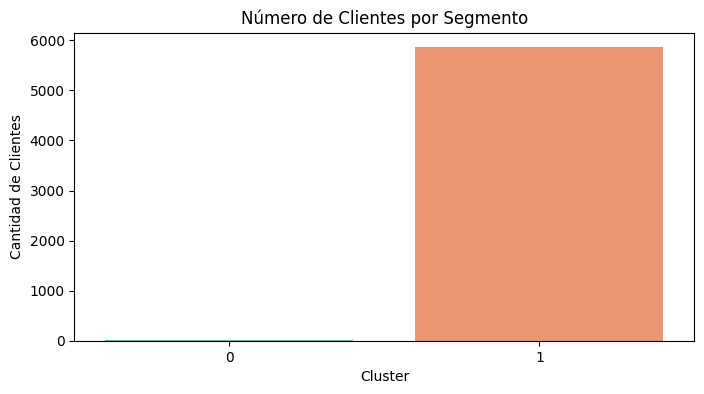

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29688\1849399127.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x="cluster", y=col, palette="Set3")


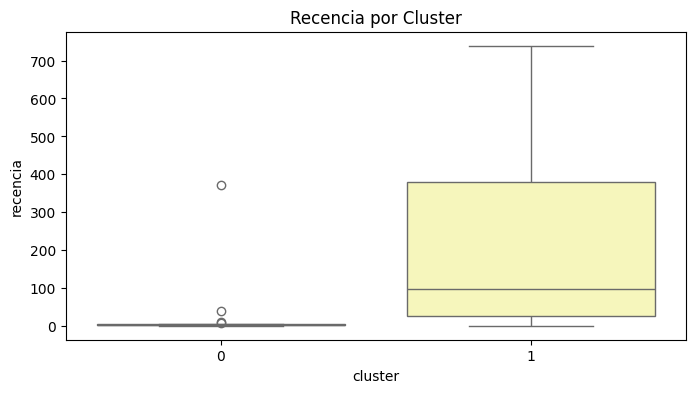

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29688\1849399127.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x="cluster", y=col, palette="Set3")


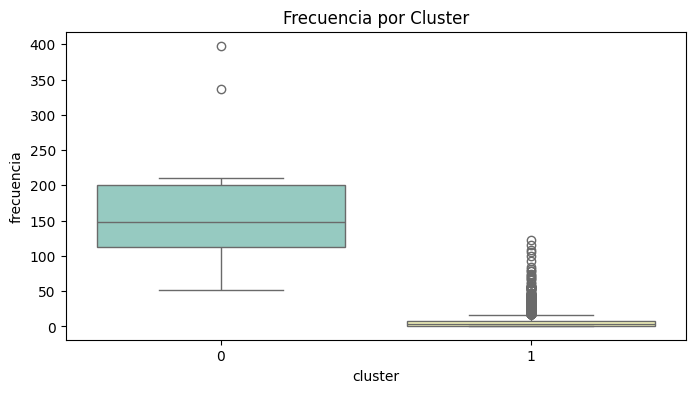

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29688\1849399127.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x="cluster", y=col, palette="Set3")


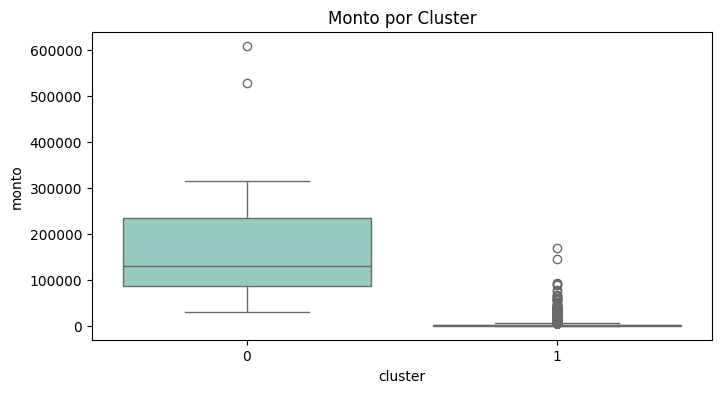

In [12]:
# 7. Visualización por cluster
import seaborn as sns
import matplotlib.pyplot as plt

# Distribución de clientes por grupo
plt.figure(figsize=(8, 4))
sns.countplot(data=rfm, x="cluster", palette="Set2")
plt.title("Número de Clientes por Segmento")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de Clientes")
plt.show()

# Boxplots por métrica
for col in ["recencia", "frecuencia", "monto"]:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=rfm, x="cluster", y=col, palette="Set3")
    plt.title(f"{col.capitalize()} por Cluster")
    plt.show()


In [10]:
# 8. Interpretación preliminar para la demo
rfm.groupby("cluster").agg({
    "recencia": "mean",
    "frecuencia": "mean",
    "monto": "mean",
    "customer_id": "count"
}).rename(columns={"customer_id": "n_clientes"}).round(2)


,recencia,frecuencia,monto,n_clientes
cluster,,,,
0,25.83,162.56,189805.09,18
1,202.41,5.81,2444.87,5860
